In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# [1]데이터 불러오기
- pykrx(네이버에서 금융 데이터 스크랩해주는 모듈) 사용

In [82]:
# pip install pykrx

In [83]:
from pykrx import stock
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
    
# ticker와 list로 코스피 기업목록 가져오기
    
def return_name(market):
    Market = []
 
    for ticker in market:
        Value =stock.get_market_ticker_name(ticker)
        Market.append([Value,ticker])
 
    df = pd.DataFrame(Market,columns=['회사명','상장번호'])
    return df

In [84]:
KOSDAQ = stock.get_market_ticker_list(market="KOSDAQ")
KOSPI = stock.get_market_ticker_list(market="KOSPI")
 
db1 = return_name(KOSPI)
db2= return_name(KOSDAQ)

In [85]:
# KOSPI

In [86]:
# for ticker in KOSPI:
#         Value =stock.get_market_ticker_name(ticker)
#         print(Value)

In [87]:
db1  # KOSPI

,회사명,상장번호
0,AJ네트웍스,095570
1,AK홀딩스,006840
2,BGF,027410
3,BGF리테일,282330
4,BNK금융지주,138930
...,...,...
918,휴켐스,069260
919,흥국화재,000540
920,흥국화재2우B,000547
921,흥국화재우,000545


In [60]:
db2 # KOSDAQ

,회사명,상장번호
0,3S,060310
1,APS홀딩스,054620
2,AP시스템,265520
3,AP위성,211270
4,CJ ENM,035760
...,...,...
1492,흥구석유,024060
1493,흥국,010240
1494,흥국에프엔비,189980
1495,희림,037440


In [61]:
db1[db1['회사명'] == '삼성전자']

,회사명,상장번호
413,삼성전자,005930


In [62]:
df = stock.get_market_ohlcv_by_date("20160104", "20210303", "005930")
df.tail()   # 삼성주가 출력해보기

,시가,고가,저가,종가,거래량
날짜,,,,,
2021-02-24,81800,83600,81300,82000,26807651
2021-02-25,84000,85400,83000,85300,34155986
2021-02-26,82800,83400,82000,82500,38520800
2021-03-02,85100,85300,83000,83600,33498180
2021-03-03,83500,84000,82800,84000,19882132


In [63]:
kospi = return_name(KOSPI)
kospi.to_csv("kospi_list.csv")   # 코스피리스트 저장   # 코스피리스트 저장

In [64]:
# 시가총액 4대 기업 주식정보가져오기

stocks=['삼성전자','SK하이닉스','NAVER','현대차']
df_res = pd.DataFrame()

for i in stocks:
    bun=db1[db1['회사명']==i]
    번호=bun.iloc[0,1]
    df_res[i] = stock.get_market_ohlcv_by_date("20160104", "20210325", 번호)['종가']

In [65]:
df_res    # 네이버 2018년 10월 액면분할

,삼성전자,SK하이닉스,NAVER,현대차
날짜,,,,
2016-01-04,24100,30150,126580,144000
2016-01-05,24160,30600,127581,143500
2016-01-06,23500,30750,124777,140000
2016-01-07,23260,30200,130585,137500
2016-01-08,23420,29700,130585,136500
...,...,...,...,...
2021-03-19,81900,138000,402000,229500
2021-03-22,82000,138000,396500,229000
2021-03-23,81800,135000,386000,226500


# [2]효율적 투자선 구하기
## 1)기초개념

In [66]:
daily_ret = df_res.pct_change()           #pct_change() 일간 수익률 구하기
annual_ret = daily_ret.mean() * 252       #일간수익률 평균에 252를 곱해서 연간 수익률 구하기

daily_cov = daily_ret.cov()               #일간 리스크
annual_cov = daily_cov * 252              #연간 리스크

In [67]:
annual_ret

삼성전자      0.275629
SK하이닉스    0.358762
NAVER     0.272100
현대차       0.140915
dtype: float64

In [68]:
annual_cov   # 각각의 분산표시 ~ 리스크의 제곱값 ~ variance-covariance matrix

,삼성전자,SK하이닉스,NAVER,현대차
삼성전자,0.073652,0.061112,0.024164,0.026351
SK하이닉스,0.061112,0.134411,0.026021,0.030213
NAVER,0.024164,0.026021,0.112890,0.025287
현대차,0.026351,0.030213,0.025287,0.120889


In [69]:
 np.random.random(4)   # 0~1사이 값 난수생성

array([0.52573765, 0.53200073, 0.5140197 , 0.40432804])

In [70]:
# 포트폴리오 비중 구하기
weights = np.random.random(len(stocks)) 
weights /= np.sum(weights)        # 총합으로 나누어 난수들 합이 1이 되도록 조정
weights                                

array([0.2640612 , 0.13638414, 0.22924011, 0.37031454])

## 2)몬테카를로 시뮬레이션
- 많은 난수를 통해 함수의 값을 확률적으로 계산

In [73]:
port_ret = []       # 포트폴리오 수익률
port_risk = []      # 포트폴리오 리스크
port_weights = []   # 종목 비중
sharpe_ratio = []   # 샤프비율 리스트 설정

for _ in range(20000):                         # 20000개의 포트폴리오 생성
    
    weights = np.random.random(len(stocks))    # 4가지 종목 난수생성
    weights /= np.sum(weights)                 # weights의 총합으로 나누어 총합 1이되게 조정

    returns = np.dot(weights, annual_ret)      #각 종목 비중과 수익률을 곱해 해당 포트폴리오의 수익률 계산
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))    #해당 포트폴리오 리스크 계산

    port_ret.append(returns)                    # 각 리스트에 append
    port_risk.append(risk) 
    port_weights.append(weights) 
    sharpe_ratio.append(returns/risk)           # 샤프지수 append

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe' : sharpe_ratio}     # portfolio 딕셔너리에 각 종목별로 비중값 추가

for i, s in enumerate(stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
    
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk','Sharpe'] + [s for s in stocks]] 

In [74]:
for i,s in enumerate(stocks):
    print('i값:',i)
    print('s값:',s)

i값: 0
s값: 삼성전자
i값: 1
s값: SK하이닉스
i값: 2
s값: NAVER
i값: 3
s값: 현대차


In [75]:
# portfolio

In [76]:
df

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,현대차
0,0.267122,0.226885,1.177345,0.268660,0.242702,0.283132,0.205507
1,0.237523,0.243169,0.976785,0.185164,0.263774,0.108260,0.442802
2,0.256190,0.227846,1.124398,0.222978,0.239729,0.251646,0.285647
3,0.250668,0.226806,1.105209,0.206715,0.161887,0.355518,0.275880
4,0.274405,0.237634,1.154735,0.714782,0.004714,0.275727,0.004777
...,...,...,...,...,...,...,...
19995,0.231084,0.229220,1.008130,0.219806,0.085178,0.320173,0.374843
19996,0.247999,0.226155,1.096589,0.235730,0.119920,0.375071,0.269279
19997,0.241041,0.252532,0.954498,0.217617,0.310793,0.023667,0.447923
19998,0.242165,0.222793,1.086950,0.316215,0.072038,0.327464,0.284283


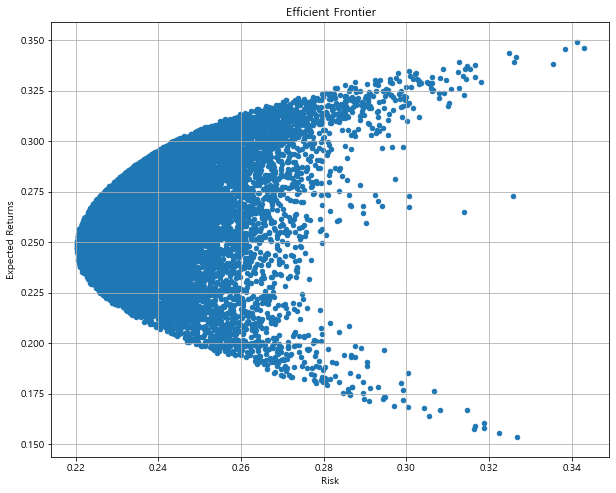

In [77]:
# 효율적 투자선 그리기
df.plot.scatter(x='Risk', y='Returns', figsize=(10, 8), grid=True)
plt.title('Efficient Frontier') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show() 

## [3] 샤프지수, 효율적 투자선

In [78]:
# Mean-Varinance portfolio(평균분산포트폴리오) : 최대 샤프지수 ~ 탄젠트
max_sharpe = df.loc[df['Sharpe'] ==df['Sharpe'].max()]
max_sharpe

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,현대차
8123,0.294267,0.238924,1.231631,0.404346,0.258811,0.323966,0.012877


In [79]:
# Mininum-Variance portfolio(최소분산포트폴리오) : 최소 Variance(=Risk)
min_risk = df.loc[df['Risk'] == df['Risk'].min()]
min_risk

,Returns,Risk,Sharpe,삼성전자,SK하이닉스,NAVER,현대차
18697,0.247919,0.220232,1.125717,0.43364,0.052884,0.282547,0.23093


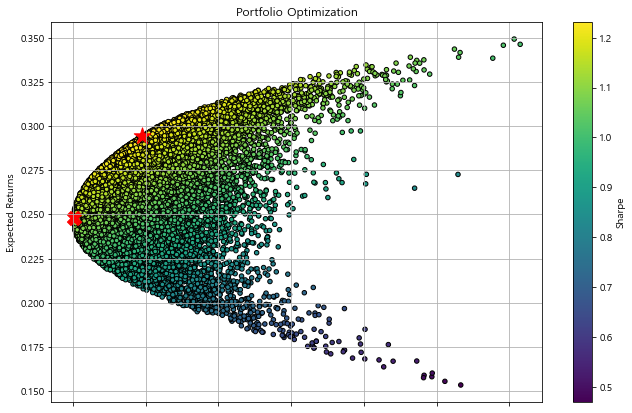

In [80]:
# minimum-variance portfolio와 mean-variance portfolio 시각화

df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis',
    edgecolors='k', figsize=(11,7), grid=True)   

plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r',      # 평균분산포트폴리오 *표시
    marker='*', s=300)  

plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r',          # 최소분산포트폴리오 X표시
    marker='X', s=200)  

plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show()

# [3]볼린저 밴드
## 1) 볼린저 밴드 그리기

- 상단 볼린저 밴드 = 중간 볼린저 밴드 + (2 X 표준편차)
- 중간 볼린저 밴드 = 종가의 20일 이동평균
- 하단 볼린저 밴드 = 중간 볼린저 밴드 - (2 X 표준편차)
#### ==> 볼린저 밴드의 폭 클 수록 변동성이 큼
- %b(볼린저 밴드지표) : 주가가 밴드의 어디에 위치하는지 알려줌(주가가 상단 밴드에 걸치면 1 하단 밴드에 걸치면 0 값을 가짐)

In [53]:
db1[db1['회사명'] == 'NAVER']

,회사명,상장번호
94,NAVER,035420


In [97]:
df = stock.get_market_ohlcv_by_date("20200425", "20210325", "035420")
df.tail()  #  네이버 주가 정보 출력

,시가,고가,저가,종가,거래량
날짜,,,,,
2021-03-19,397000,407500,395000,402000,1258199
2021-03-22,402500,405500,393000,396500,911358
2021-03-23,397000,399000,384000,386000,1167110
2021-03-24,380000,387000,376000,387000,763754
2021-03-25,381500,384000,378000,380000,672585


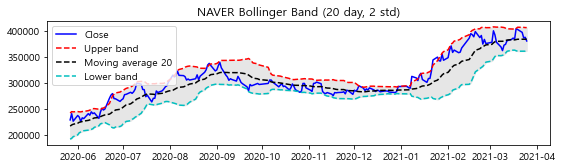

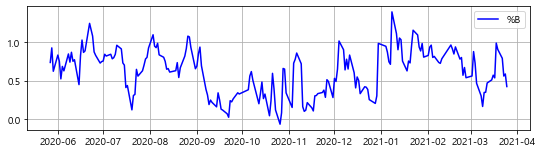

In [98]:
import matplotlib.pyplot as plt

  
df['MA20'] = df['종가'].rolling(window=20).mean()       # 중간 볼린저 밴드
df['stddev'] = df['종가'].rolling(window=20).std() 
df['upper'] = df['MA20'] + (df['stddev'] * 2)           # 상단 볼린저 밴드
df['lower'] = df['MA20'] - (df['stddev'] * 2)           # 하단 볼린저 밴드
df['PB'] = (df['종가']-df['lower'])/(df['upper']-df['lower'])    # %b
df = df[19:]  

plt.figure(figsize=(9, 5))
plt.subplot(2,1,1)
plt.plot(df.index, df['종가'], color='#0000ff', label='Close')    
plt.plot(df.index, df['upper'], 'r--', label = 'Upper band')       
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label = 'Lower band')

plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')     # 상단 하단 사이 회색칠
plt.legend(loc='best')
plt.title('NAVER Bollinger Band (20 day, 2 std)')
plt.show()

plt.figure(figsize=(9, 5))
plt.subplot(2, 1, 2)  
plt.plot(df.index, df['PB'], color='b', label='%B') 
plt.grid(True)
plt.legend(loc='best')
plt.show()

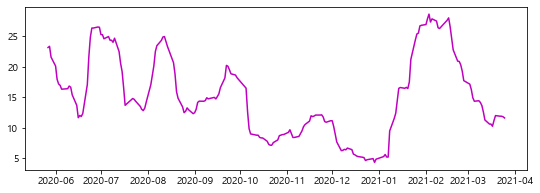

In [62]:
# 밴드폭 시각화
# 밴드폭 = (상단 볼린저밴드 - 하단 볼린저 밴드) / 중간 볼린저 밴드 

df['bandwidth'] = (df['upper'] - df['lower']) / df['MA20'] * 100    
plt.figure(figsize=(9,3))
plt.plot(df.index, df['bandwidth'], color='m', label='BandWidth')

# 기술적 분석
- 시가,고가,저가, 거래량 등을 고려
- 볼린저 밴드
신고가,
이동평균선,
일목균형표,
스토캐스틱,
모멘텀,
양봉,
ADX,
ATR,
MACD,
RSI,
캔들차트 등

## 2)추세 추종매매기법
### MFI(현금흐름지표, Money Flow Index)
- 가격과 거래량을 동시에 고려(현금흐름)
- 긍정적 현금 흐름 : 중심 가격이 전일보다 상승한 날들의 현금 흐름의 합
- 부정적 현금 흐름 : 중심 가격이 전일보다 하락한 날들의 현금 흐름의 합

### $$MFI = 100 - {100 \over 1+(긍정적 현금 흐름/부정적 현금 흐름)}$$

In [100]:
df = stock.get_market_ohlcv_by_date("20200425", "20210325", "035420")  # 네이버주가 데이터 refresh

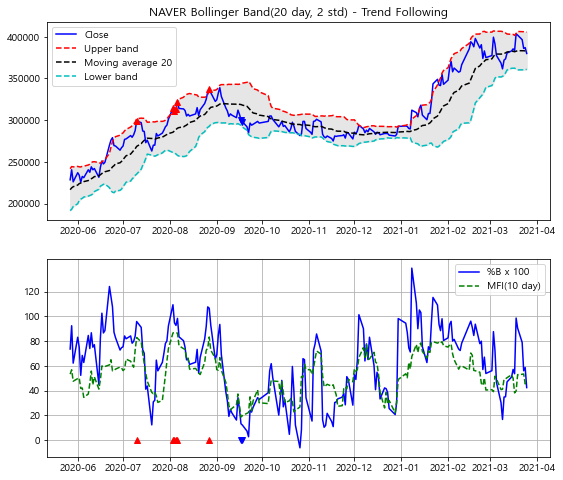

In [101]:
import matplotlib.pyplot as plt
  
df['MA20'] = df['종가'].rolling(window=20).mean() 
df['stddev'] = df['종가'].rolling(window=20).std() 
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['종가'] - df['lower']) / (df['upper'] - df['lower'])    # %b
df['TP'] = (df['고가'] + df['저가'] + df['종가']) / 3                  # 고가,저가,종가의 평균으로 중심 가격 구하기         
df['PMF'] = 0
df['NMF'] = 0


for i in range(len(df.종가)-1):
    if df.TP.values[i] < df.TP.values[i+1]:                             # 긍정적 현금흐름
        df.PMF.values[i+1] = df.TP.values[i+1] * df.거래량.values[i+1]
        df.NMF.values[i+1] = 0
    else:
        df.NMF.values[i+1] = df.TP.values[i+1] * df.거래량.values[i+1]    # 부정적 현금흐름
        df.PMF.values[i+1] = 0
df['MFR'] = (df.PMF.rolling(window=10).sum() /             # 긍정적 현금흐름/부정적 현금흐름
    df.NMF.rolling(window=10).sum())
df['MFI10'] = 100 - 100 / (1 + df['MFR'])                  # MFI공식적용

df = df[19:]

plt.figure(figsize=(9, 8))
plt.subplot(2, 1, 1)
plt.title('NAVER Bollinger Band(20 day, 2 std) - Trend Following')
plt.plot(df.index, df['종가'], color='#0000ff', label='Close')
plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(len(df.종가)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:       # %b가 0.8보다크고 MFI가 80보다 크면 매수표시
        plt.plot(df.index.values[i], df.종가.values[i], 'r^')    
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:     # %b가 0.2보다작고 MFI가 20보다 작으면 매도표시
        plt.plot(df.index.values[i], df.종가.values[i], 'bv')  
plt.legend(loc='best')

plt.subplot(2, 1, 2)
plt.plot(df.index, df['PB'] * 100, 'b', label='%B x 100')       # %b 푸른색
plt.plot(df.index, df['MFI10'], 'g--', label='MFI(10 day)')     # MFI 녹색 점선
plt.yticks([-20, 0, 20, 40, 60, 80, 100, 120])                  
for i in range(len(df.종가)):
    if df.PB.values[i] > 0.8 and df.MFI10.values[i] > 80:
        plt.plot(df.index.values[i], 0, 'r^')
    elif df.PB.values[i] < 0.2 and df.MFI10.values[i] < 20:
        plt.plot(df.index.values[i], 0, 'bv')
plt.grid(True)
plt.legend(loc='best')
plt.show();   

## 3) 반전 매매 기법
### 일중강도와 반전매매 구현
- 일중강도(II): 시가,고가,저가,종가 그리고 거래량까지 고려
- 일중강도률(II%): (일중강도의21일합/거래량의 21일 합) * 100
- 개별주식과 시장가격 함께고려
- 큰손(기관 블록 거래자)들의 거래방향

In [88]:
df = stock.get_market_ohlcv_by_date("20200425", "20210325", "035420")  # 네이버주가 데이터 refresh

C:\Users\Owner\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Owner\.conda\envs\test\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


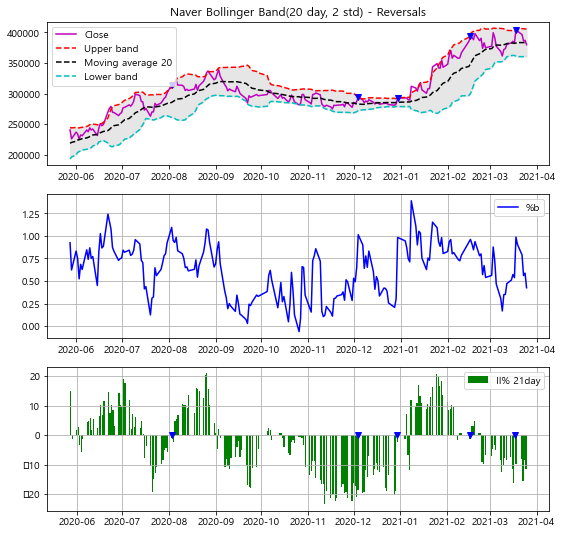

In [89]:
import matplotlib.pyplot as plt
  
df['MA20'] = df['종가'].rolling(window=20).mean() 
df['stddev'] = df['종가'].rolling(window=20).std() 
df['upper'] = df['MA20'] + (df['stddev'] * 2)
df['lower'] = df['MA20'] - (df['stddev'] * 2)
df['PB'] = (df['종가'] - df['lower']) / (df['upper'] - df['lower'])

df['II'] = (2*df['종가']-df['고가']-df['저가'])/(df['고가']-df['저가'])*df['거래량']
df['IIP21'] = df['II'].rolling(window=21).sum()/df['거래량'].rolling(window=21).sum()*100       #II% 식 적용
df = df.dropna()

plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
plt.title('Naver Bollinger Band(20 day, 2 std) - Reversals')
plt.plot(df.index, df['종가'], 'm', label='Close')
plt.plot(df.index, df['upper'], 'r--', label ='Upper band')
plt.plot(df.index, df['MA20'], 'k--', label='Moving average 20')
plt.plot(df.index, df['lower'], 'c--', label ='Lower band')
plt.fill_between(df.index, df['upper'], df['lower'], color='0.9')
for i in range(0, len(df.종가)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:       # %b 0.05보다 작고 II%가 0보다 크면 매수
        plt.plot(df.index.values[i], df.종가.values[i], 'r^')  
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:     # %b 0.95보다 크고 II%가 0보다 작으면 매도
        plt.plot(df.index.values[i], df.종가.values[i], 'bv')  
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(df.index, df['PB'], 'b', label='%b')
plt.grid(True)
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.bar(df.index, df['IIP21'], color='g', label='II% 21day')
for i in range(0, len(df.종가)):
    if df.PB.values[i] < 0.05 and df.IIP21.values[i] > 0:
        plt.plot(df.index.values[i], 0, 'r^') # ⑤
    elif df.PB.values[i] > 0.95 and df.IIP21.values[i] < 0:
        plt.plot(df.index.values[i], 0, 'bv') # ⑥
plt.grid(True)
plt.legend(loc='best')
plt.show()